# California Housing Prices

In [2]:
import os 
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

import optuna
from typing import List
from tqdm import tqdm
import warnings
# Adjust display settings for better readability
pd.set_option("display.max_rows", 100)  # Adjust maximum rows to show
pd.set_option("display.max_columns", 10)  # Adjust maximum columns to show
pd.set_option("display.width", 1000)  # Set display width to accommodate all columns
pd.set_option("display.colheader_justify", "left")  # Left-justify column headers
pd.set_option("display.float_format", "{:.3f}".format)  # Floating-point precision to 3 decimals
warnings.filterwarnings('ignore')
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("data")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
colors = [
    "#03256C",
    "#2541B2",
    "#1768AC",
    "#E5D549",
]
sns.set_palette(sns.color_palette(colors))


/Users/aaronnguyen/Documents/PersonalProjects/housing_price_prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# def fetch_data(url=HOUSING_URL, path=HOUSING_PATH):
#     if not os.path.isdir(path):
#         os.makedirs(path)
#     tgz_path = os.path.join(path,"housing.tgz")
#     urllib.request.urlretrieve(url, tgz_path)
#     data = tarfile.open(tgz_path)
#     data.extractall(path=path)
#     data.close()

def load_data(path=HOUSING_PATH):
    csv_path = os.path.join(path,'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
try:
    if not os.path.isdir(HOUSING_PATH):
        os.makedirs(HOUSING_PATH)
        fetch_data()
except:
  print('An exception occurred')

df= load_data(path=HOUSING_PATH)

In [5]:
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value ocean_proximity
 0 -122.230   37.880    41.000               880.000      129.000         322.000     126.000    8.325          452600.000           NEAR BAY      
 1 -122.220   37.860    21.000              7099.000     1106.000        2401.000    1138.000    8.301          358500.000           NEAR BAY      
 2 -122.240   37.850    52.000              1467.000      190.000         496.000     177.000    7.257          352100.000           NEAR BAY      
 3 -122.250   37.850    52.000              1274.000      235.000         558.000     219.000    5.643          341300.000           NEAR BAY      
 4 -122.250   37.850    52.000              1627.000      280.000         565.000     259.000    3.846          342200.000           NEAR BAY      ,
 None,
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  me

In [6]:
target_col = 'median_house_value'
num_cols = df.select_dtypes(include=[np.number]).columns.values
cat_cols = df.select_dtypes(exclude=[np.number]).columns.values
num_cols,cat_cols

(array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value'], dtype=object),
 array(['ocean_proximity'], dtype=object))

- Conclusion: 
  - Numerical Feature: `['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value']`

  - Categorical Feature: ` 'ocean_proximity'`
  - Target Feature: `'median_house_value'`

# Sanity Check

In [7]:
df.isna().sum()*100 / df.shape[0]

longitude            0.000
latitude             0.000
housing_median_age   0.000
total_rooms          0.000
total_bedrooms       1.003
population           0.000
households           0.000
median_income        0.000
median_house_value   0.000
ocean_proximity      0.000
dtype: float64

In [8]:
df.isna()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value  ocean_proximity
0      False      False     False               False        False           False       False       False          False               False          
1      False      False     False               False        False           False       False       False          False               False          
2      False      False     False               False        False           False       False       False          False               False          
3      False      False     False               False        False           False       False       False          False               False          
4      False      False     False               False        False           False       False       False          False               False          
...          ...       ...                 ...          ...             ...         ...         ...            ...                 ...              ...
20635  False      False     False               False        False           False       False       False          False               False          
20636  False      False     False               False        False           False       False       False          False               False          
20637  False      False     False               False        False           False       False       False          False               False          
20638  False      False     False               False        False           False       False       False          False               False          
20639  False      False     False               False        False           False       False       False          False               False          

[20640 rows x 10 columns]

<Axes: >

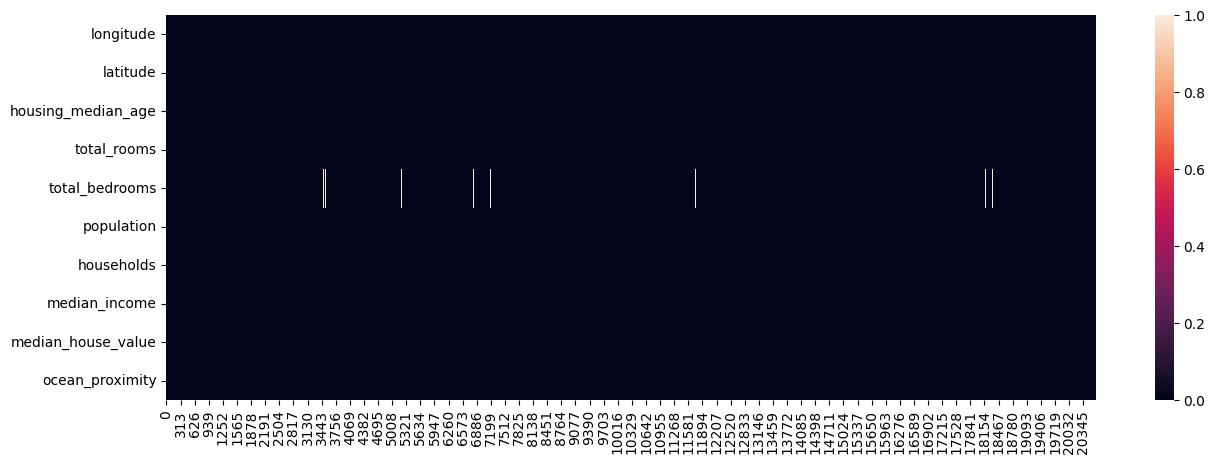

In [9]:
_, ax = plt.subplots(figsize=(15,5))
sns.heatmap(
    df.isna().transpose(),
    ax = ax
)

In the above code snippet, we're generating a heatmap to visualize the distribution of missing values in our DataFrame, `df`. The heatmap is structured such that each column of `df` is represented on the x-axis, and each row corresponds to a boolean value indicating the presence (or absence) of missing data.

The color intensity in the heatmap provides a quick, visual representation of our data's completeness. Dark cells indicate that the corresponding data point in `df` is not missing, while lighter cells signify missing or NaN values. This visualization technique allows us to quickly identify patterns or clusters of missing data, which can be incredibly useful in the data cleaning and preprocessing stages of our analysis.

## Duplication

In [10]:
df.duplicated().sum()

0

# Discussion:

- Observations:
    - We've identified that the `total_bedrooms` column has approximately 1% of its data missing.
    - Upon checking for duplicate entries, we found that our dataset does not contain any duplications.

# EDA

In [11]:
def displot(df: pd.DataFrame, target_col: str, bins: int):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

    sns.histplot(
        df[target_col], 
        bins=bins,
        ax=ax1)
    ax1.set(
        title=f'Histogram of {target_col} column',
        ylabel='Frequency',
        xlabel=target_col
    )

    stats.probplot(df[target_col], plot=ax2)
    ax2.set(
        title=f'Q-Q plot of {target_col} column'
    )
    plt.show()

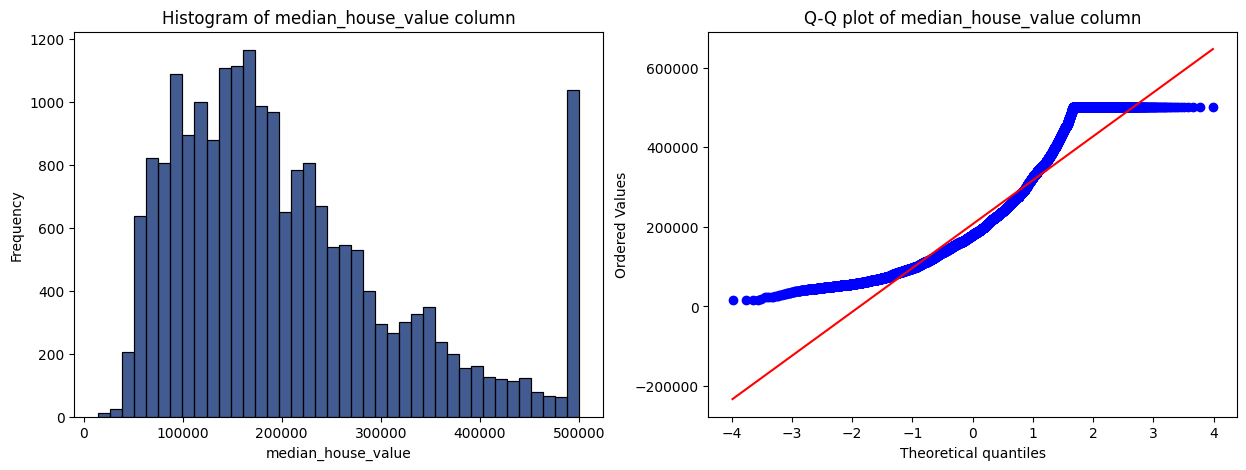

In [12]:
bins=40 
displot(df, target_col, bins)

In [13]:
max_value = df[target_col].max()
df.query(f'{target_col} == {max_value}').shape[0]

965

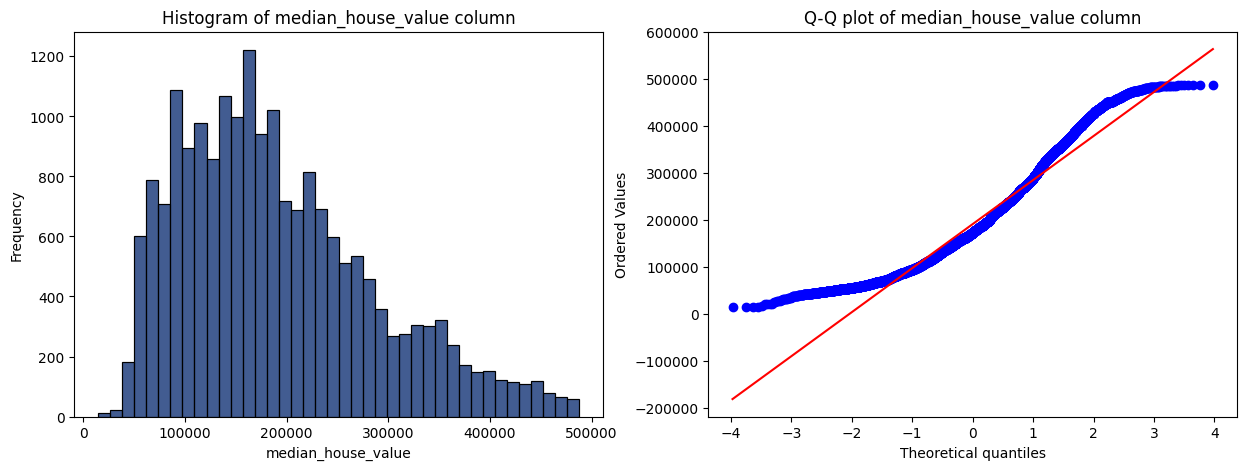

In [14]:
displot(df.query(f'median_house_value < {max_value - round(max_value/bins)}'), target_col, bins)

## Feature

### Categorical Features

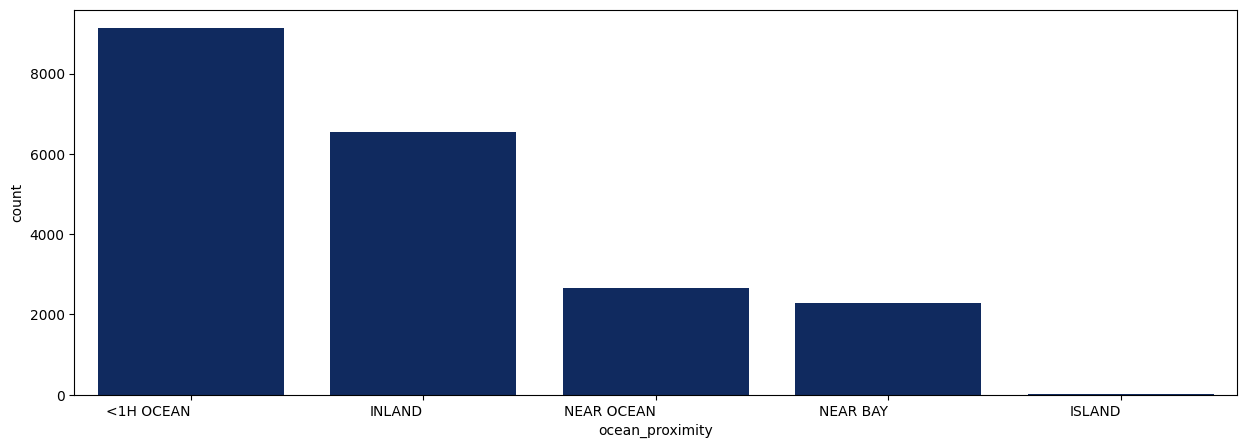

In [15]:
_, ax = plt.subplots(figsize=(15,5))
order = df[cat_cols[0]].value_counts().index
sns.countplot(
    data=df, 
    x=cat_cols[0], 
    ax=ax, 
    order = order)

ax.set_xticks(
    ax.get_xticks(), 
    ax.get_xticklabels(), 
    rotation=0, 
    ha='right')
plt.show()

In [16]:
df.loc[df[cat_cols[0]] == 'ISLAND']

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value ocean_proximity
8314 -118.320   33.350    27.000              1675.000     521.000          744.000    331.000     2.158          450000.000           ISLAND        
8315 -118.330   33.340    52.000              2359.000     591.000         1100.000    431.000     2.833          414700.000           ISLAND        
8316 -118.320   33.330    52.000              2127.000     512.000          733.000    288.000     3.391          300000.000           ISLAND        
8317 -118.320   33.340    52.000               996.000     264.000          341.000    160.000     2.736          450000.000           ISLAND        
8318 -118.480   33.430    29.000               716.000     214.000          422.000    173.000     2.604          287500.000           ISLAND

In [17]:
summ_df = (
    df.groupby(cat_cols[0])['median_house_value']
    .agg(['mean', 'median', 'std'])
    .sort_values('mean')
)

summ_df.round(2)

mean       median     std      
ocean_proximity                                 
INLAND          124805.390 108500.000  70007.910
<1H OCEAN       240084.290 214850.000 106124.290
NEAR OCEAN      249433.980 229450.000 122477.150
NEAR BAY        259212.310 233800.000 122818.540
ISLAND          380440.000 414700.000  80559.560

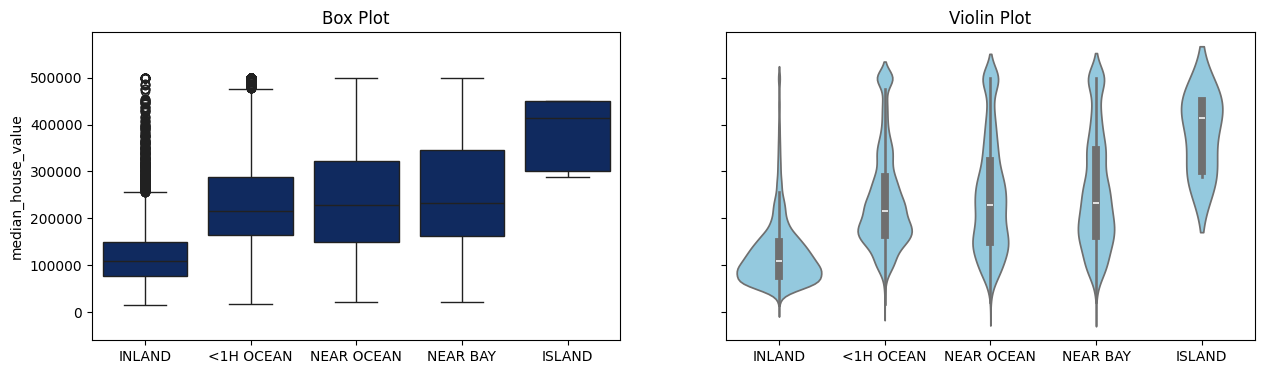

In [18]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharey=True)

sns.boxplot(data=df, 
            x=cat_cols[0], 
            y='median_house_value', 
            order=summ_df.index.to_list(), 
            ax=ax1)
ax1.set(xlabel='', title='Box Plot')

sns.violinplot(data=df, 
               x=cat_cols[0], 
               y='median_house_value', 
               order=summ_df.index.to_list(), 
               ax=ax2,
               color='skyblue')
ax2.set(xlabel='', title='Violin Plot')

plt.show()

### Numerical Features

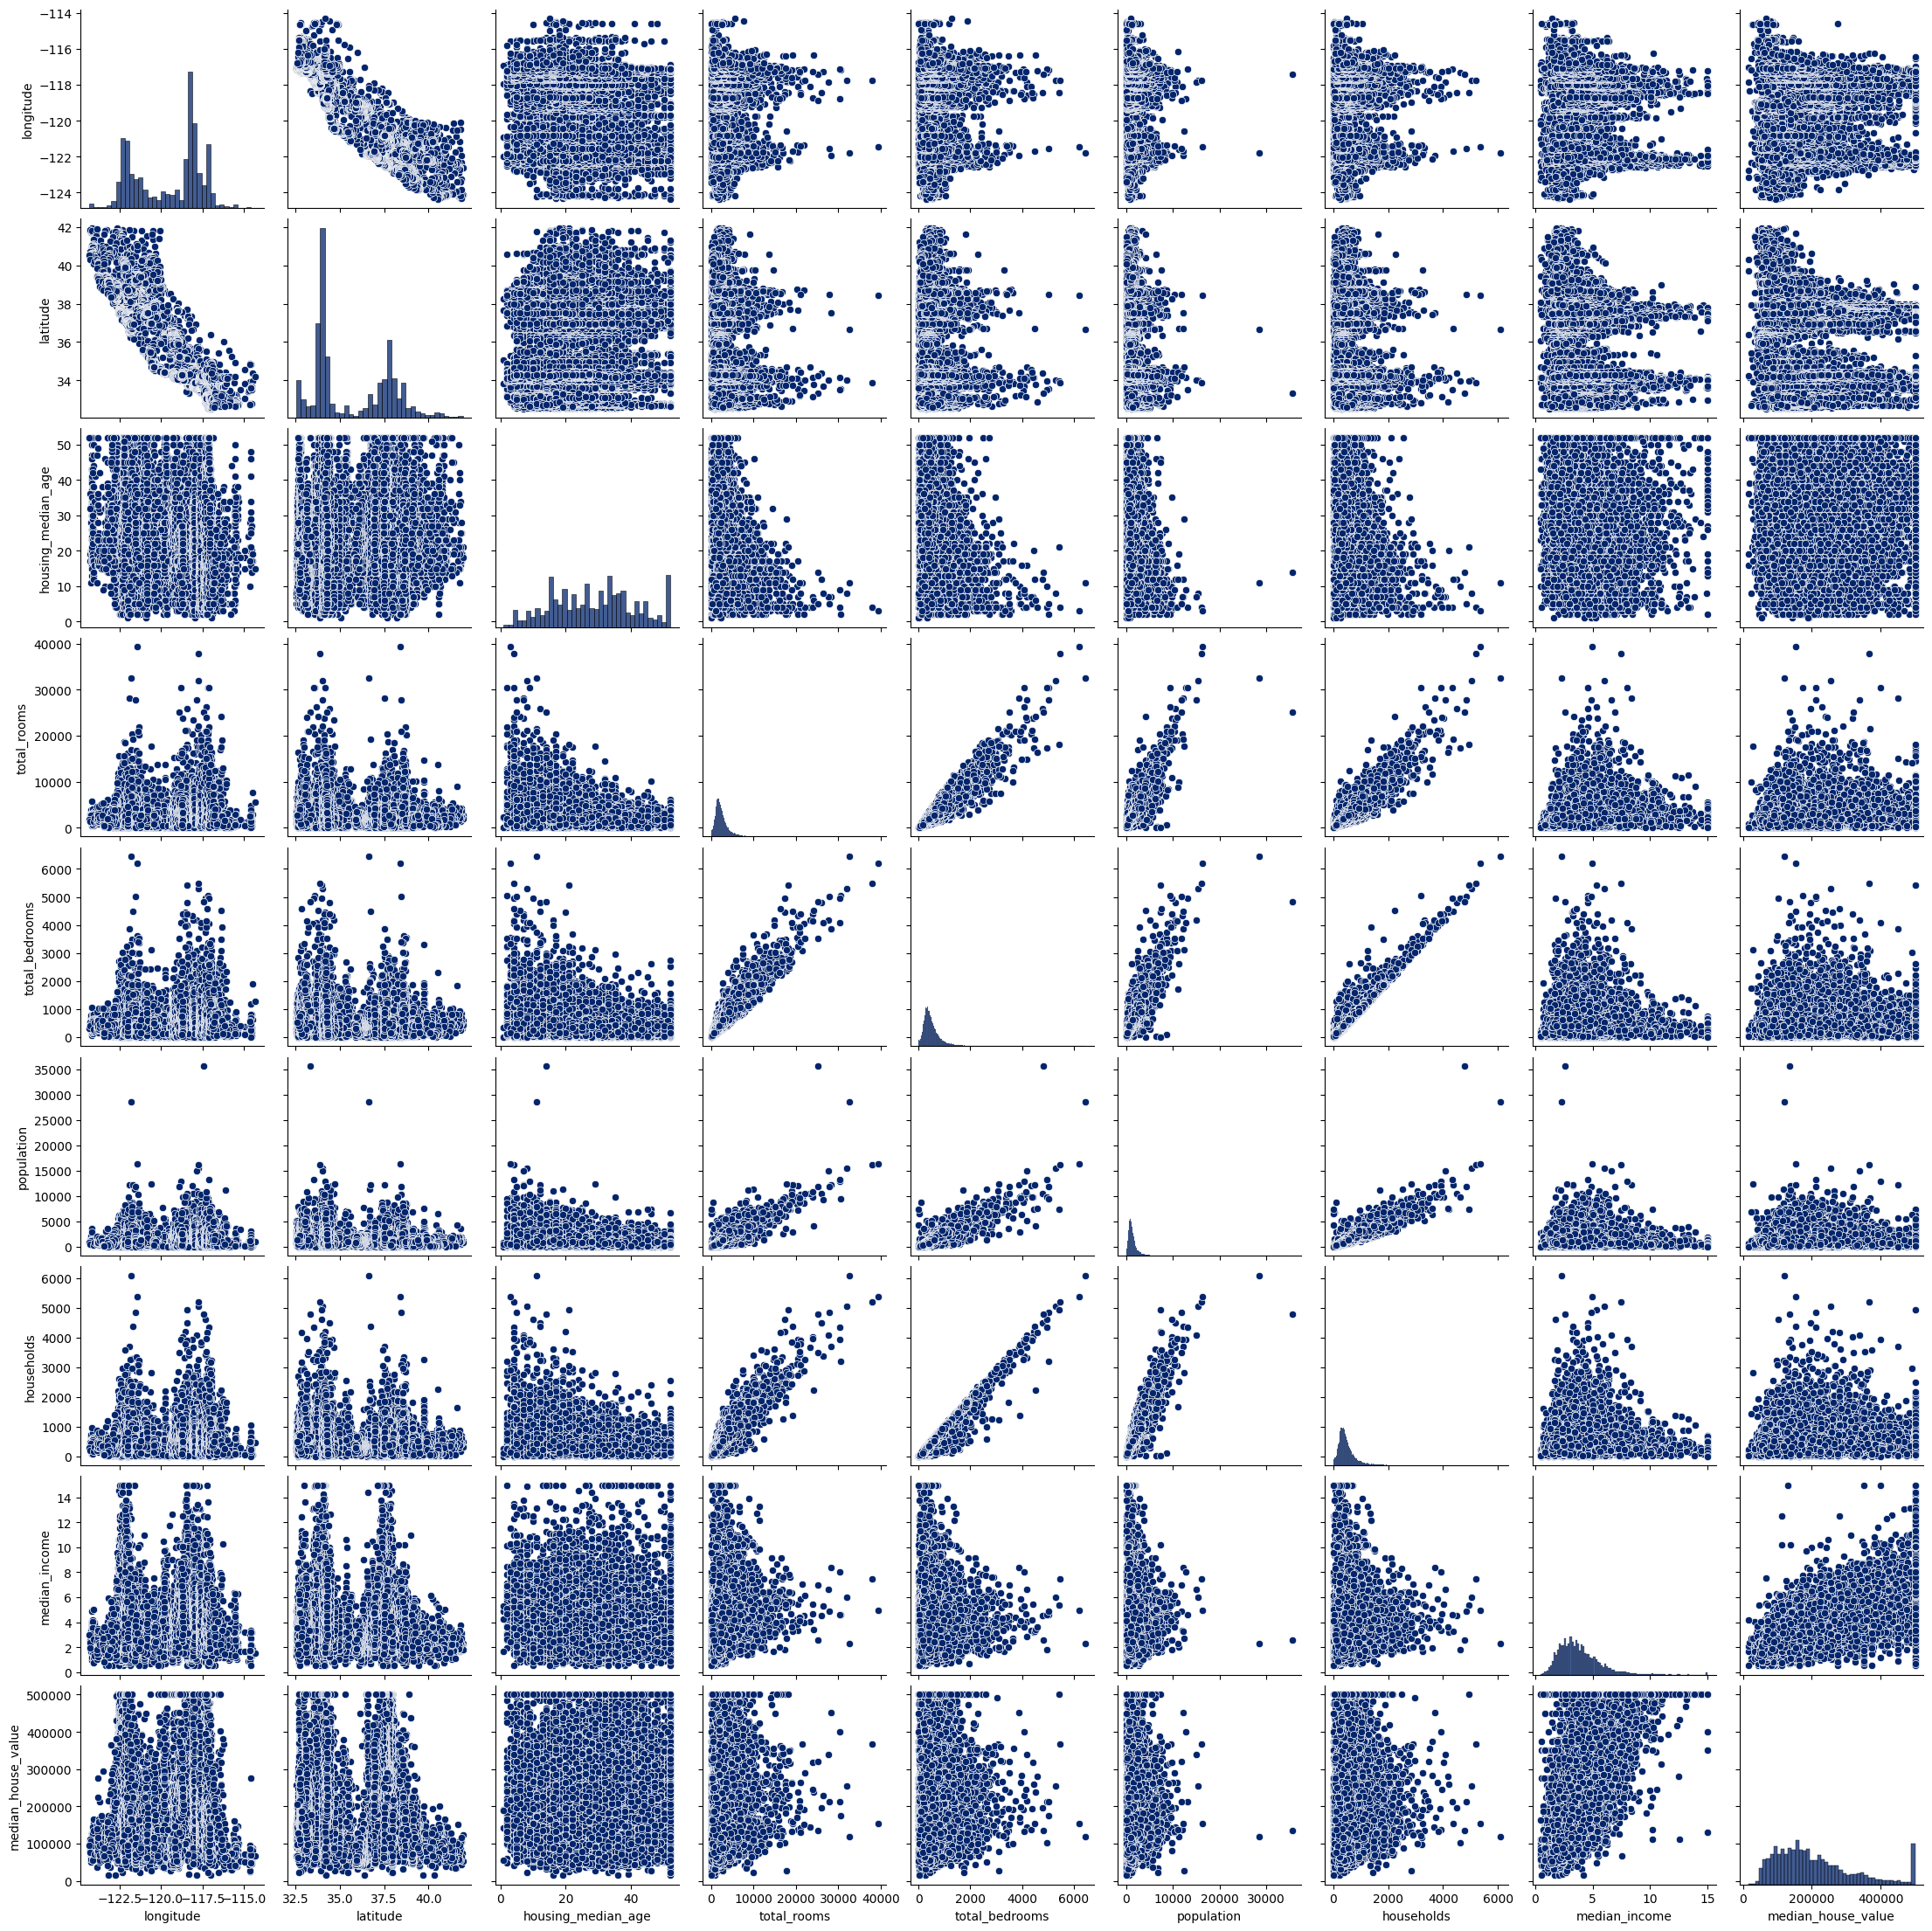

In [19]:
sns.pairplot(df[num_cols])

In [20]:
def plot_heatmap(df_corr, title):
    _, ax = plt.subplots(figsize=(8,6))
    
    ones_corr = np.ones_like(df_corr, dtype=bool)
    
    mask = np.triu(ones_corr)
    adjusted_mask = mask[1:, :-1] 
    adjusted_df_corr = df_corr.iloc[1:, :-1]

    yticks = [i.lower() for i in adjusted_df_corr.index]
    xticks = [i.lower() for i in adjusted_df_corr.columns]

    sns.heatmap(data=adjusted_df_corr, mask=adjusted_mask,
                annot=True, annot_kws={"fontsize":10}, fmt=".2f", 
                vmin=-1, vmax=1,
                linecolor='white', linewidths=0.5)

    ax.set_yticklabels(yticks, rotation=0, fontsize=10)
    ax.set_xticklabels(xticks, rotation=90, fontsize=10)
    plot_title = f'CORRELATION MATRIX\n{title.upper()}\n'
    ax.set_title(plot_title, loc='left', fontsize=14)
    plt.tight_layout()
    plt.show()
    

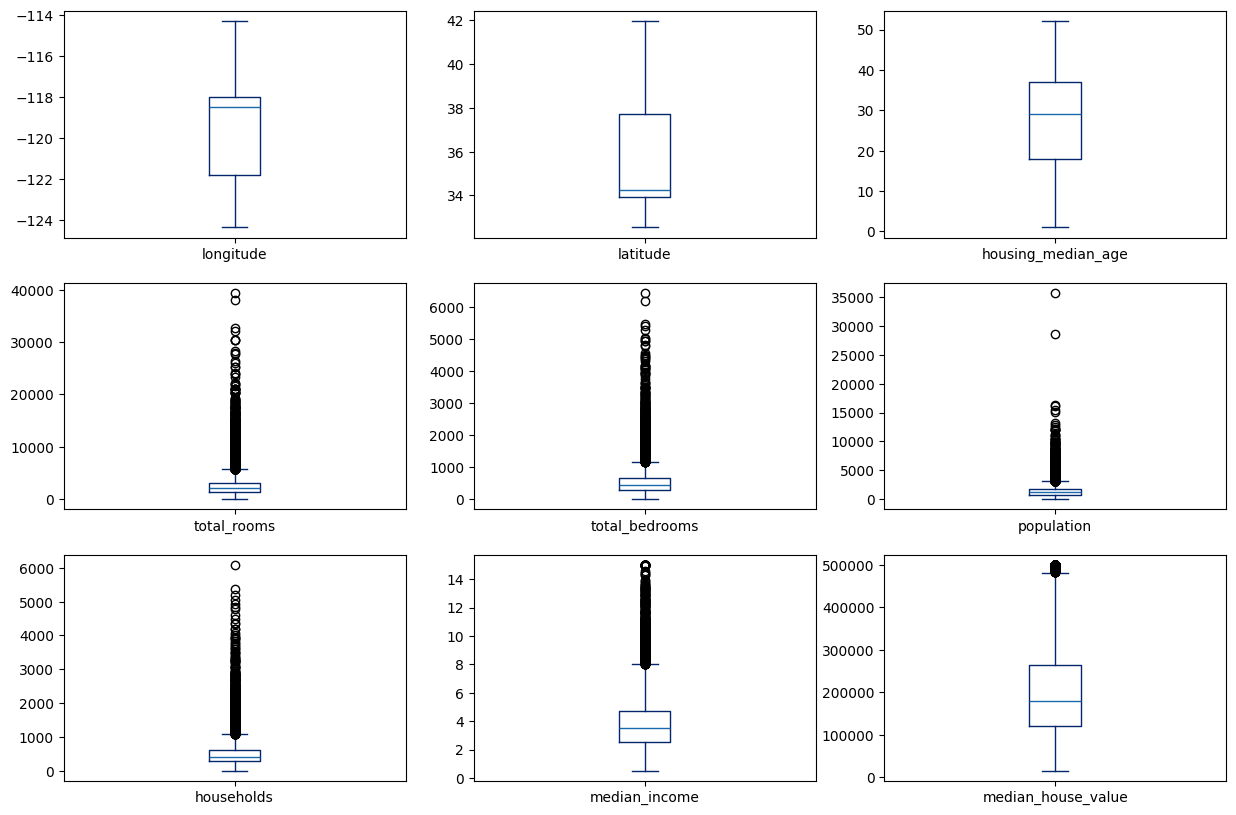

In [21]:
df.plot(kind='box',
        subplots=True,
        layout=(3,3),
        sharex=False,
        sharey=False,
        figsize=(15,10)
)
plt.show()

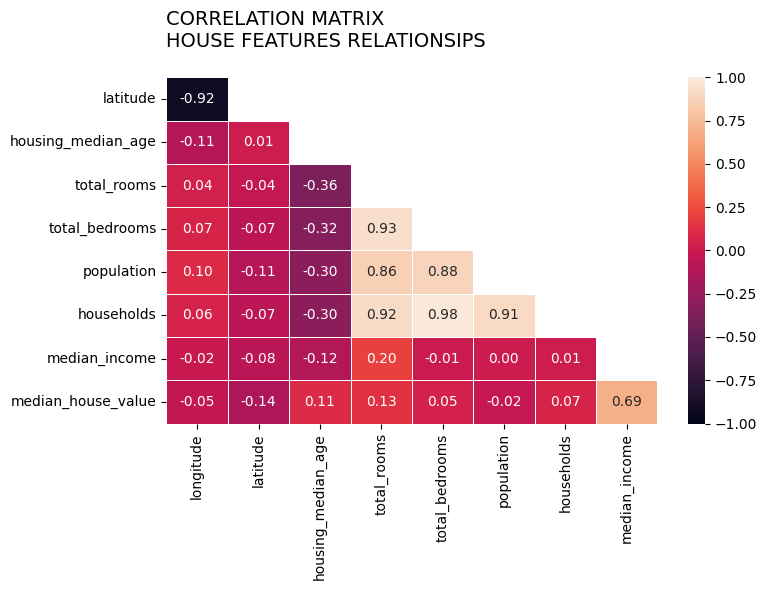

In [22]:
corr_mat = df.corr(numeric_only=True)
plot_heatmap(corr_mat, 'House Features Relationsips')

In [23]:
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64

In [24]:
df['room_p_house'] = df['total_rooms'] / df['households']
df['bedrom_p_house'] = df['total_bedrooms'] / df['total_rooms']
df['people_p_house'] = df['population'] / df['households']
df.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000
median_income         0.688
room_p_house          0.152
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
people_p_house       -0.024
population           -0.025
longitude            -0.046
latitude             -0.144
bedrom_p_house       -0.256
Name: median_house_value, dtype: float64

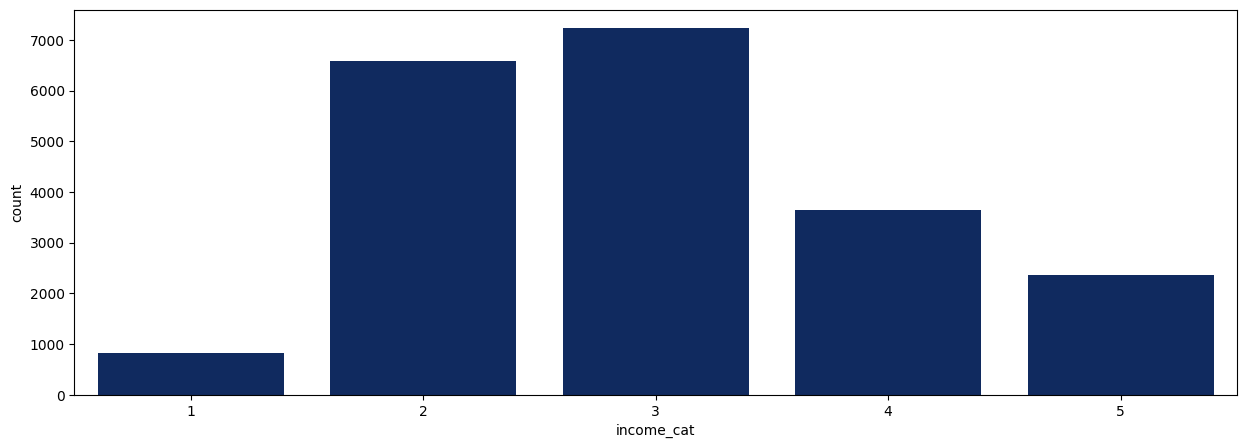

In [25]:
df['income_cat'] = pd.cut(
    df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1,2,3,4,5]
)
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='income_cat')
plt.show()

- Based on the `income_cat` do the stratified sampling

<Axes: xlabel='income_cat', ylabel='Count'>

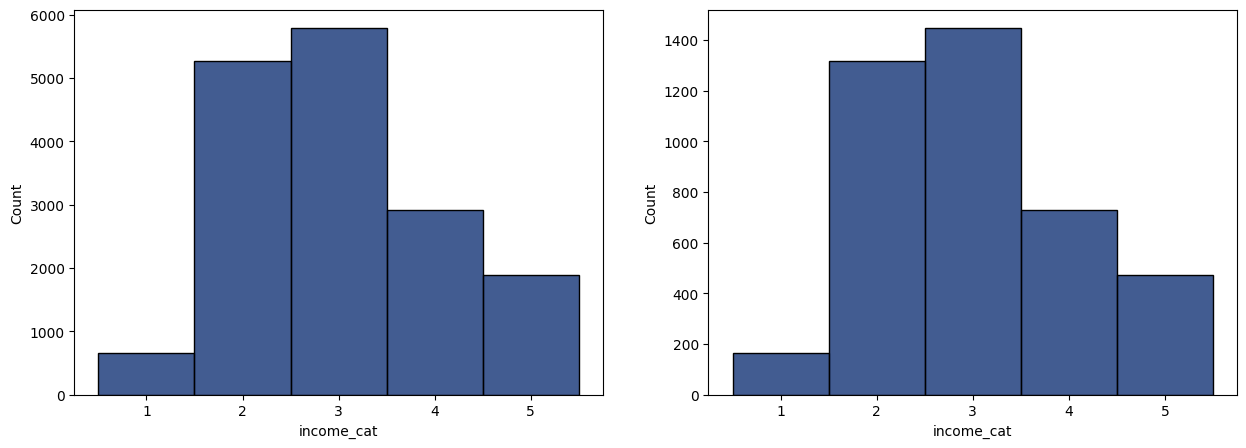

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits = 1,
    test_size=0.2,
    random_state=21
)

for train_i, test_i in split.split(df, df['income_cat']):
    train_set = df.loc[train_i]
    test_set = df.loc[test_i]
    
_, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(train_set['income_cat'], bins=30, ax=axes[0])
sns.histplot(test_set['income_cat'], bins=30, ax=axes[1]) 

In [27]:
exploring_data = train_set.copy()

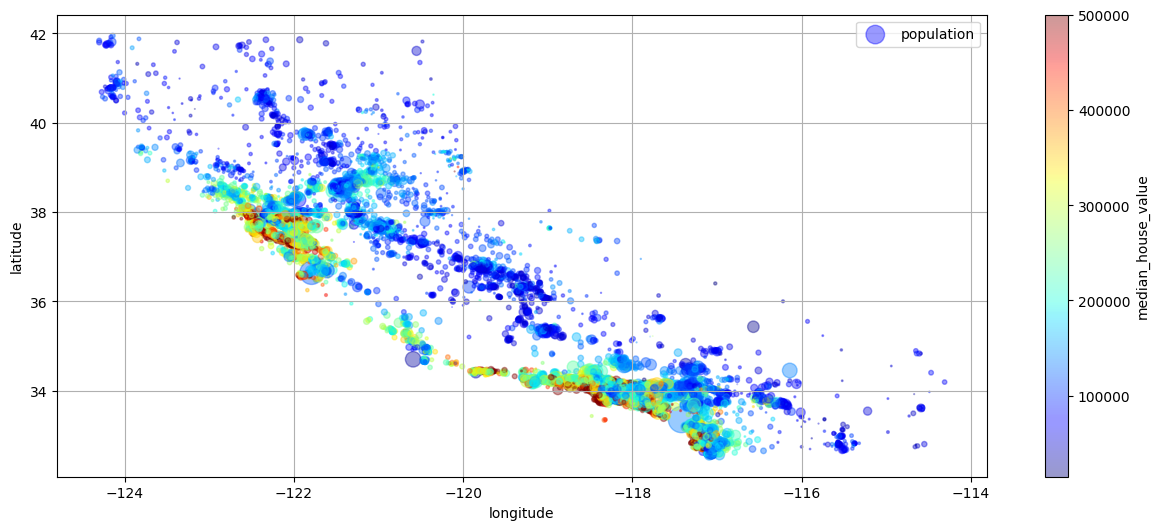

In [28]:
exploring_data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                     s=exploring_data["population"] / 100, label="population",
                     figsize=(15,6),c='median_house_value',
                     cmap=plt.get_cmap("jet"), colorbar=True,
                     legend=True, sharex=False, alpha=0.4)
plt.legend()
plt.show()

# Prepare data for ML model

In [29]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13641 to 6043
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16336 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  room_p_house        16512 non-null  float64 
 11  bedrom_p_house      16336 non-null  float64 
 12  people_p_house      16512 non-null  float64 
 13  income_cat          16512 non-null  category
dtypes: category(1), float64(12), object(1)
memory usage: 1.8+ MB
<class 'pandas.core.frame.D

(None, None)

In [30]:
from sklearn.metrics.pairwise import rbf_kernel
age_sim_35 = rbf_kernel(train_set[['latitude', 'longitude']], gamma=0.1)


In [31]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

In [32]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 n_clusters=5, 
                 gamma=1.0, 
                 random_state=42):
        self.n_clusters = n_clusters   
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters, 
            random_state=self.random_state
        )
        self.kmeans_.fit(X)
        return self
    
    def transform(self, X):
        return rbf_kernel(
            X, 
            self.kmeans_.cluster_centers_,
            gamma=self.gamma
        )
        
    def get_fnames(self, names=None):
        return [f"Cluster_{i} similarity" for i in range(self.n_clusters)]

In [33]:
cluster_simis = ClusterSimilarity(n_clusters=10, gamma=1)
simis = (
    cluster_simis
    .fit(train_set[['latitude', 'longitude']])
    .transform(train_set[['latitude', 'longitude']])
)

In [34]:
simis[0].round(2)

array([0.4 , 0.  , 0.26, 0.  , 0.  , 0.89, 0.  , 0.  , 0.  , 0.  ])

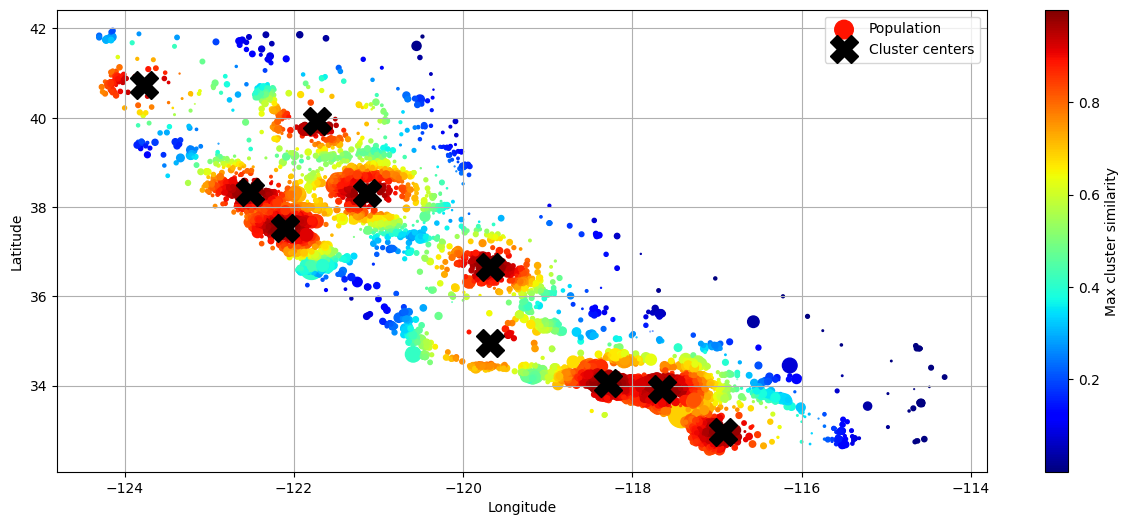

In [35]:
housing_renamed = train_set.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = simis.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(15, 6))
plt.plot(cluster_simis.kmeans_.cluster_centers_[:, 1],
         cluster_simis.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

## Data Preprocessing

In [36]:
features = np.append(
    num_cols,
    cat_cols
)

get_features = lambda df: df.loc[
    :,
    features[features != target_col]
]
get_target = lambda df: df[target_col]

X_train, y_train = get_features(train_set), get_target(train_set)
X_test, y_test = get_features(test_set), get_target(test_set)

In [37]:
X_train

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income ocean_proximity
13641 -117.330   34.050    26.000                613.000     149.000         431.000     130.000     1.398             INLAND     
12439 -116.180   33.670    25.000               2888.000     654.000        2940.000     660.000     2.214             INLAND     
12218 -117.230   33.570     6.000              13724.000    2269.000        5860.000    1986.000     3.962          <1H OCEAN     
8447  -118.370   33.900    32.000                332.000     103.000         177.000     102.000     3.341          <1H OCEAN     
4843  -118.290   34.030    27.000               1084.000     287.000        1085.000     279.000     2.135          <1H OCEAN     
...          ...       ...                 ...          ...             ...         ...         ...            ...             ...
19207 -122.720   38.460    35.000               1445.000     309.000         795.000     308.000     2.907          <1H OCEAN     
1583  -121.970   37.870     4.000               1029.000     126.000         416.000     122.000    13.488             INLAND     
19866 -119.320   36.330    18.000               2603.000     478.000        1158.000     423.000     4.594             INLAND     
17394 -120.440   34.960    39.000               1228.000     379.000         851.000     341.000     1.899          <1H OCEAN     
6043  -117.740   34.050    29.000               2452.000     700.000        3029.000     665.000     2.135             INLAND     

[16512 rows x 9 columns]

In [38]:
class DataPrep:
    def __init__(
        self,
        num_features: List[str],
        iqr_bound: float = 1.5,
        log_target: bool = False,
        direction: str = 'both'
    ):
        """_summary_

        Args:
            num_features (List[str]): _description_
            iqr_bound (float, optional): _description_. Defaults to 1.5.
            log_target (bool, optional): _description_. Defaults to False.
        """
        self.num_features = num_features
        self.iqr_bound = iqr_bound
        self.log_target = log_target
        self.dir = direction
        self.lower_bound = None
        self.upper_bound = None
        
    def fit(
        self,
        X: pd.DataFrame,
    ):
        """_summary_

        Args:
            X (pd.DataFrame): _description_
        """
        q1 = X[self.num_features].quantile(0.25)
        q3 = X[self.num_features].quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - self.iqr_bound * iqr
        self.upper_bound = q3 + self.iqr_bound * iqr

        return self
    def transform(
        self,
        X: pd.DataFrame,
        y: pd.Series,
    ) -> pd.DataFrame:
        X = X.copy()
        X = self._rm_outliers(X)
        if self.log_target:
            y = np.log1p(y)
        return X,y
        
    def _rm_outliers(self, df: pd.DataFrame):
        for col in self.num_features:
            df.loc[
                df[col] < self.lower_bound[col],
                col
            ] = self.lower_bound[col]
            
            df.loc[
                df[col] > self.upper_bound[col],
                col
            ] = self.upper_bound[col]
        return df


In [39]:
X_train_prep, y_train_prep = (
    DataPrep(num_features=num_cols[num_cols != target_col])
    .fit(X_train)
    .transform(X_train, y_train)
)

X_test_prep, y_test_prep = (
    DataPrep(num_features=num_cols[num_cols != target_col])
    .fit(X_train)
    .transform(X_test, y_test)
)


In [40]:
import numpy as np  # Add this import statement

from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def ratio_pl():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda cols: cols[:, [0]] / cols[:, [1]], feature_names_out='one-to-one'),
        StandardScaler()
    )

def binning_pl(n_bins, encode, strategy):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    )

log_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)


simi_pl = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

default_num_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer([
    ('bedroom_p_room', ratio_pl(), ['total_bedrooms', 'total_rooms']),
    ('rooms_p_house', ratio_pl(), ['total_rooms', 'households']),
    ('pp_p_house', ratio_pl(), ['population', 'households']),
    # ('bin', binning_pl(n_bins=7, encode='onehot', strategy='quantile'), ['housing_median_age']),
    ('log', log_pl, ['median_income', 'total_bedrooms', 'total_rooms', 'population', 'households']),
    ('cat', cat_pl, make_column_selector(dtype_include=object)),
    ('geo', simi_pl, ['latitude', 'longitude'])
], remainder=default_num_pl)


In [41]:
preprocessor.fit(X_train_prep)

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedroom_p_room',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function ratio_pl.<locals>.<lambda> at 0x...
                                 ['median_income', 'total_bedrooms',
                                  'total_rooms', 'population', 'households']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x159c2a6f0>),
                                ('geo',
                                 ClusterSimilarity(gamma=1, n_clusters=10),
                                 ['latitude', 'longitude'])])

In [56]:

from sklearn.model_selection import cross_val_score, cross_validate
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm

class ModelTrainer:
    def __init__(self, models, preprocessor):
        """
        Initialize the cross-validation trainer.
        :param model: An sklearn estimator object or similar model object.
        :param preprocessor: A defined feature transformation object.
        
        """
        self.models = models
        self.preprocessor = preprocessor
        self.cv_results = None
    
        
    def fit(self, X, y, scoring, nsplits=10, nrepeats=3, random_state=42):
        """
        Train the model(s) using cross-validation.
        
        :param X: The input features (training data).
        :param y: The target labels/values.
        :return: A summary of cross-validation scores.
        """
        self.scoring = scoring
        self.cv_results = [
            
            cross_validate(
                
                Pipeline(steps=[
                    ('preprocessor', self.preprocessor),
                    ('model', model)
                ]),
                
                X, y,
                cv= RepeatedStratifiedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=random_state),
                scoring=scoring,
                n_jobs=6
            )
            
            for model in tqdm(self.models)
        ]
        return self

    # def evaluate(self):
    #     """
    #     Evaluate model performance across folds using cross-validation.
        
    #     :param X: The input features (evaluation data).
    #     :param y: The target labels/values.
    #     :return: A summary of evaluation scores.
    #     """
    #     if not self.cv_results:
    #         raise ValueError("The models must be trained with `fit` before evaluation.")
        
    #     means = [np.mean(-res) for res in self.cv_results]
    #     stds = [np.std(-res) for res in self.cv_results]

    #     print({
    #         "mean":means, 
    #         "std": stds
    #     })
    #     return self
    
    def evaluate(self):
        """
        Evaluate model performance across folds using cross-validation.

        :return: A DataFrame containing a summary of evaluation scores for each model and metric.
        """
        if not self.cv_results or not self.scoring:
            raise ValueError("The models must be trained with `fit` before evaluation.")

        # Create an empty DataFrame to store all scores
        columns = ["Model"]
        for metric in self.scoring:
            columns.append(f"Mean {metric}")
            columns.append(f"Std {metric}")

        # Prepare a summary DataFrame for each model's scores
        summary_data = []
        for model, results in zip(self.models, self.cv_results):
            row = [model.__class__.__name__]
            for metric in self.scoring:
                scores = results[f'test_{metric}']
                mean_score = -np.mean(scores)
                std_score = np.std(scores)
                row.append(mean_score)
                row.append(std_score)
            summary_data.append(row)

        # Create a DataFrame from the summary data
        self.cv_results = pd.DataFrame(summary_data, columns=columns)
        return self
    def get_results(self):
        return self.cv_results
    

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor


models = [
    LinearRegression()
    ,Ridge(), Lasso(), 
    ElasticNet(),GradientBoostingRegressor(), 
    RandomForestRegressor(), XGBRegressor()
]

In [58]:
trainer = ModelTrainer(models, preprocessor).fit(X_train_prep, y_train_prep, ['neg_root_mean_squared_error'])

 29%|██▊       | 2/7 [00:01<00:04,  1.14it/s]/Users/aaronnguyen/Documents/PersonalProjects/housing_price_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+12, tolerance: 1.967e+10
  model = cd_fast.enet_coordinate_descent(
/Users/aaronnguyen/Documents/PersonalProjects/housing_price_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e+12, tolerance: 1.969e+10
  model = cd_fast.enet_coordinate_descent(
/Users/aaronnguyen/Documents/PersonalProjects/housing_price_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_

In [59]:
df = trainer.evaluate().get_results()

<Axes: ylabel='Model'>

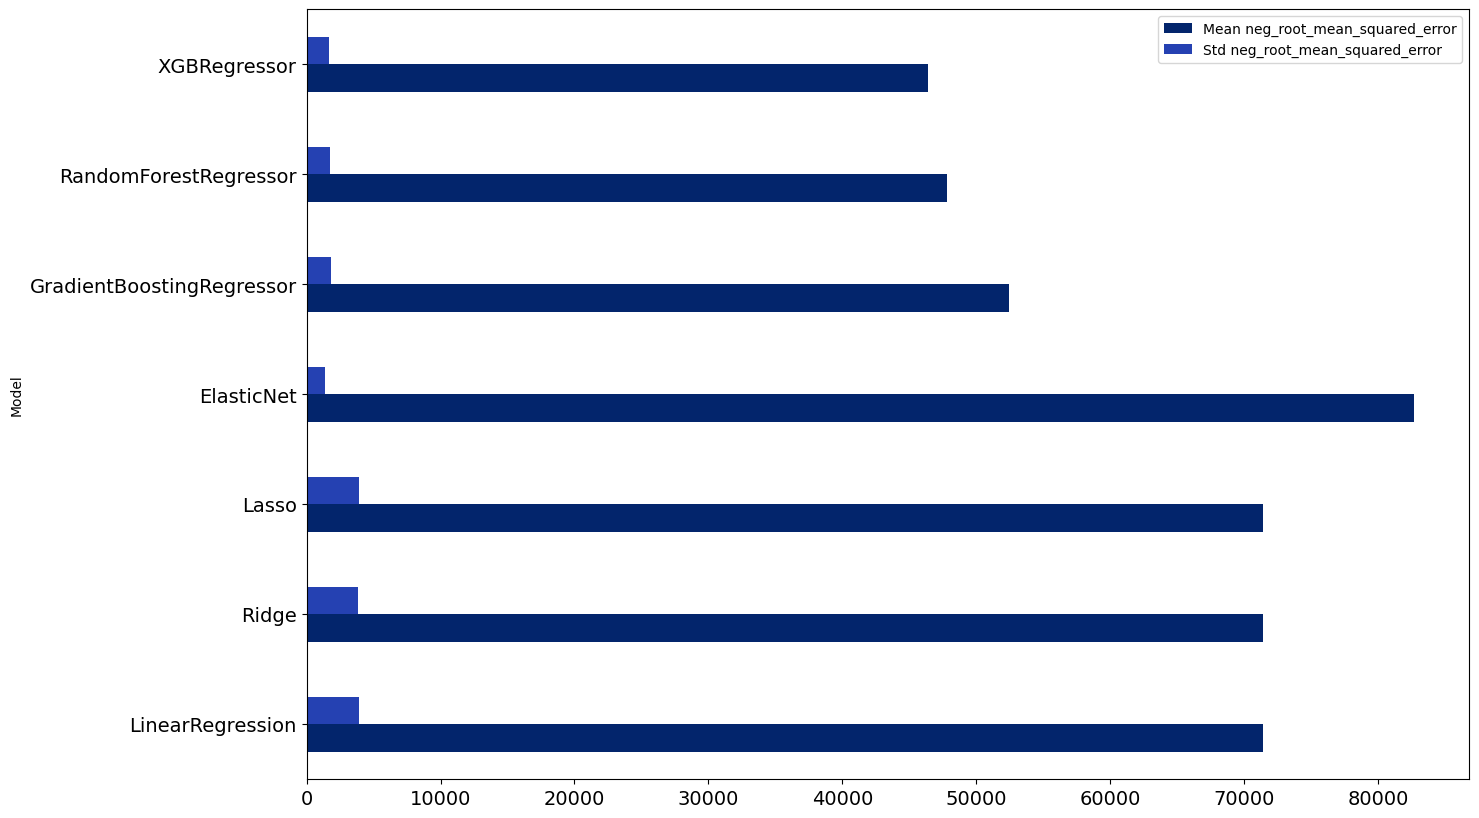

In [61]:
df.set_index('Model').plot(kind='barh', figsize=(15,10), fontsize=14)

# Fine-Tune Model

## Grid Search

In [66]:
from sklearn.model_selection import GridSearchCV

In [63]:
class ModelSwitcher(BaseEstimator):
    def __init__(self, estimator=LinearRegression()):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X, y):
        return self.estimator.score(X, y)

In [69]:
pl = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', ModelSwitcher())
])

param_grid = {
    'model__estimator': [XGBRegressor()],
    'pre__geo__n_clusters': [5, 10, 15],
    'pre__geo__gamma': [0.1, 0.5, 1.0],
    'model__estimator__max_depth': [6,7,10],
    'model__estimator__learning_rate': [0.08, 0.1, 0.02],
}

In [74]:
gscv = GridSearchCV(
    pl,
    param_grid,
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=7,
    verbose=3
)

In [75]:
gscv.fit(X_train_prep, y_train_prep)

Fitting 30 folds for each of 81 candidates, totalling 2430 fits
[CV 7/30] END model__estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__estimator__learning_rate=0.08, model__estimator__max_depth=6, pre__geo__gamma=0.1, pre__geo__n_clusters=5;, score=-49341.528 total time=   0.5s
[CV 4/

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedroom_p_room',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('fu...
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...)],
                         'model__estimator__learning_rate': [0.08, 0.1, 0.02],
                         'model__estimator__max_depth': [6, 7, 10],
                         'pre__geo__gamma': [0.1, 0.5, 1.0],
                         'pre__geo__n_clusters': [5, 10, 15]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [80]:
-gscv.best_score_

45528.37635186468

In [81]:
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedroom_p_room',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function ratio_p...
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=10,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)))])